In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/mask_rcnn/dene7.zip"

# **Detectron2 Yükleme**


In [ ]:

!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9


In [ ]:

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.


In [ ]:

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.


In [ ]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog


Burada, veri seti kendi özel formatındadır, bu nedenle onu ayrıştırmak ve onu dedektör2'nin standart formatına hazırlamak için bir fonksiyon yazıyoruz. Kullanıcı, özel biçimde bir veri kümesi kullanırken böyle bir işlevi kullanmalıdır.
# **Verileri Detectron2 Yapılandırmasına Uygun Şekilde Kaydetme**

In [ ]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}

        filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = filename
        record["height"] = 800
        record["width"] = 800

        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": classes.index(anno['label']),
                "segmentation": [poly],
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


In [ ]:

classes = ['bosluk']

data_path = '/content/dene7/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "my_" + d,
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("my_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("my_train")

# **Detectron2 Segmentasyon Modelinin Eğitimi**

In [ ]:

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from matplotlib.patches import Rectangle


# **Yapılandırma Dosyasını Oluşturma**

In [ ]:

cfg = get_cfg() # Yapılandırma Dosyasını Oluşturuyoruz
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")) # Yapılandırma Dosyasını Çeker ve Yapılandırma Dosyasına Ekler
cfg.DATASETS.TRAIN = ("my_train",) # Train Verilerimiz Yapılandırma Dosyasına Kaydeder
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2 # Çalışan Sayısı
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml") # Ağırlıkları Çeker ve Yapılandırma Dosyasına Ekler
cfg.SOLVER.IMS_PER_BATCH = 2 # Batch Size
cfg.SOLVER.BASE_LR = 0.001 # Learning Rate (Öğrenme Oranı)
cfg.SOLVER.GAMMA = 0.05 # Learning Rate Azaltma Çarpımı
cfg.SOLVER.STEPS = [500] # Learning Rate Azaltma Adım Sayısı
cfg.TEST.EVAL_PERIOD = 200 # Eğitim Sırasında Modeli Değerlendirmek İçin Adım Sayısı

cfg.SOLVER.MAX_ITER = 10000 # İterasyon Sayısı
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Sınıf Sayısı


In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) # Model Sonucu İçin Klasör Oluşturur
trainer = DefaultTrainer(cfg) # Modeli Train Moduna Geçirir Yapılandırma Dosyası ile Birlikte
trainer.resume_or_load(resume=False) # Model Eğitimine 0'dan Başlamak İçin False Yapıyoruz

In [ ]:
trainer.train() # Model Eğitimine Başlar


[03/03 10:14:55 d2.engine.train_loop]: Starting training from iteration 0
[03/03 10:15:23 d2.utils.events]:  eta: 3:53:38  iter: 19  total_loss: 2.371  loss_cls: 0.8439  loss_box_reg: 0.1009  loss_mask: 0.6918  loss_rpn_cls: 0.5623  loss_rpn_loc: 0.1758  time: 1.4055  data_time: 0.0217  lr: 1.931e-06  max_mem: 4663M
[03/03 10:15:52 d2.utils.events]:  eta: 3:57:51  iter: 39  total_loss: 2.377  loss_cls: 0.7833  loss_box_reg: 0.1021  loss_mask: 0.6919  loss_rpn_cls: 0.5543  loss_rpn_loc: 0.2884  time: 1.4343  data_time: 0.0131  lr: 2.911e-06  max_mem: 4663M
[03/03 10:16:23 d2.utils.events]:  eta: 4:00:54  iter: 59  total_loss: 2.246  loss_cls: 0.6953  loss_box_reg: 0.1316  loss_mask: 0.6912  loss_rpn_cls: 0.547  loss_rpn_loc: 0.189  time: 1.4604  data_time: 0.0097  lr: 3.891e-06  max_mem: 4663M
[03/03 10:16:53 d2.utils.events]:  eta: 4:03:32  iter: 79  total_loss: 2.006  loss_cls: 0.5818  loss_box_reg: 0.1024  loss_mask: 0.6898  loss_rpn_cls: 0.4917  loss_rpn_loc: 0.1152  time: 1.4777  d

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output


ModuleNotFoundError: ignored

# **Eğitilmiş Model testi**

In [ ]:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # Ağırlık Dosyamızı Yapılandırma Dosyamıza Kaydeder
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # Test için Eşik Değerimiz
cfg.DATASETS.TEST = ("my_test", ) # Tets Verilerimiz Yapılandırma Dosyasına Kaydeder
predictor = DefaultPredictor(cfg) #Modeli Test Moduna Geçirir Yapılandırma Dosyası ile Birlikte
test_metadata = MetadataCatalog.get("my_test")
test_dataset_dicts = get_data_dicts(data_path+'test', classes)

# **Resim Testi**

In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
for d in random.sample(test_dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                  # metadata=MetadataCatalog.get("train"),
                   metadata=microcontroller_metadata,
                   scale=0.8,
                   #instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (20, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

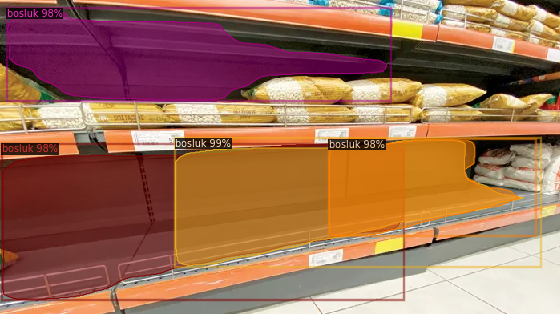

In [ ]:

from detectron2.utils.visualizer import ColorMode
import glob
from google.colab.patches import cv2_imshow
for imageName in glob.glob('/content/2-15082022f075fa28.webp'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
